In [1]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)
from utils.process_data import user_item_interaction_scores
from utils.data_exploration import perform_eda, data_sparsity, articles_clicks, plot_article_clicks
from parquet_data_reader import ParquetDataReader

import polars as pl
pl.Config.set_tbl_cols(-1)
import numpy as np

parquet_reader = ParquetDataReader()

## Data Extraction

Here, the data is extracted from the .parquet files retrieved from the website: https://recsys.eb.dk/dataset/

It is also processed using the *user_item_interaction_scores* method.

In [2]:
train_behavior_df = parquet_reader.read_data("../../data/train/behaviors.parquet")
embeddings_df = parquet_reader.read_data("../../data/document_vector.parquet")
article_df = parquet_reader.read_data("../../data/articles.parquet")
test_behavior_df = parquet_reader.read_data("../../data/validation/behaviors.parquet")
processed_behavior_df = user_item_interaction_scores(train_behavior_df, article=article_df)

In [3]:
#Creates a dictionary mapping dataset names to their corresponding DataFrames
datasets = {
    "train_behavior_df": train_behavior_df,
    "embeddings_df": embeddings_df,
    "article_df": article_df,
    "test_behavior_df": test_behavior_df,
    "processed_behavior_df": processed_behavior_df
}

results = []

for name, df in datasets.items():
    #Calculates the total number of null values by summing the counts from each column.
    total_nulls = sum(df.null_count().row(0))
    results.append({"Parquet Name": name, "Null Counts": total_nulls})

results_df = pl.DataFrame(results)

output_dir = os.path.join("summary")
os.makedirs(output_dir, exist_ok=True)

#Specifies the path for the output CSV file
output_csv = os.path.join(output_dir, "Null_Counts_Dataset_Parquets.csv")

#Writes the results DataFrame to a CSV file
results_df.write_csv(output_csv)

#Prints a confirmation message indicating successful file creation
print(f"CSV file successfully written to: {output_csv}")

CSV file successfully written to: summary\Null_Counts_Dataset_Parquets.csv


## Exploratory Data Analysis
For the EDA, the following util method was created (*perform_eda*).
Below, the method is used to print information about the Ekstra Bladet News Recommendation Dataset. 

The *perform_eda* is used to print information about the tables' schema, general description, first few entries and null counts.

### 'Behaviors' Data Exploration
Downloaded as the *behaviors.parquet* file.

In [4]:
perform_eda(train_behavior_df, name="Train Behaviors")

=== Train Behaviors ===

-- Schema --


,Column,Dtype
0,impression_id,UInt32
1,article_id,Int32
2,impression_time,"Datetime(time_unit='us', time_zone=None)"
3,read_time,Float32
4,scroll_percentage,Float32
5,device_type,Int8
6,article_ids_inview,List(Int32)
7,article_ids_clicked,List(Int32)
8,user_id,UInt32
9,is_sso_user,Boolean



-- Describe --


,statistic,impression_id,article_id,impression_time,read_time,scroll_percentage,device_type,article_ids_inview,article_ids_clicked,user_id,is_sso_user,gender,postcode,age,is_subscriber,session_id,next_read_time,next_scroll_percentage
0,count,2.328870e+05,7.042100e+04,232887,232887.000000,69098.000000,232887.000000,232887.0,232887.0,2.328870e+05,232887.000000,16219.000000,4673.000000,6341.000000,232887.000000,2.328870e+05,226669.000000,206617.000000
1,null_count,0.000000e+00,1.624660e+05,0,0.000000,163789.000000,0.000000,0.0,0.0,0.000000e+00,0.000000,216668.000000,228214.000000,226546.000000,0.000000,0.000000e+00,6218.000000,26270.000000
2,mean,2.882795e+08,9.765423e+06,2023-05-21 16:43:32.126653,43.901806,99.566208,1.685521,NaN,NaN,1.313502e+06,0.101337,0.107590,1.438048,55.013405,0.066212,9.891061e+05,68.649857,69.112617
3,std,1.683194e+08,1.296827e+05,None,90.299965,4.944662,0.519545,NaN,NaN,7.370205e+05,NaN,0.309871,1.436164,13.891898,NaN,5.682560e+05,172.633560,32.253510
4,min,1.494740e+05,3.198681e+06,2023-05-18 07:00:01,0.000000,7.000000,1.000000,NaN,NaN,1.006800e+04,0.000000,0.000000,0.000000,0.000000,0.000000,4.060000e+02,0.000000,0.000000
5,25%,1.420387e+08,9.772032e+06,2023-05-19 18:51:21,11.000000,100.000000,1.000000,NaN,NaN,6.866610e+05,NaN,0.000000,0.000000,50.000000,NaN,5.004290e+05,7.000000,36.000000
6,50%,2.903336e+08,9.774297e+06,2023-05-21 16:46:53,21.000000,100.000000,2.000000,NaN,NaN,1.328699e+06,NaN,0.000000,1.000000,60.000000,NaN,9.911210e+05,21.000000,80.000000
7,75%,4.331668e+08,9.776882e+06,2023-05-23 10:46:53,45.000000,100.000000,2.000000,NaN,NaN,1.954176e+06,NaN,0.000000,3.000000,60.000000,NaN,1.477665e+06,62.000000,100.000000
8,max,5.801007e+08,9.780271e+06,2023-05-25 06:59:58,1799.000000,100.000000,3.000000,NaN,NaN,2.590637e+06,1.000000,1.000000,4.000000,90.000000,1.000000,2.030118e+06,1799.000000,100.000000



-- Head --


,impression_id,article_id,impression_time,read_time,scroll_percentage,device_type,article_ids_inview,article_ids_clicked,user_id,is_sso_user,gender,postcode,age,is_subscriber,session_id,next_read_time,next_scroll_percentage
0,149474,NaN,2023-05-24 07:47:53,13.0,NaN,2,"[9778623, 9778682, 9778669, 9778657, 9778736, ...",[9778657],139836,False,NaN,NaN,NaN,False,759,7.0,22.0
1,150528,NaN,2023-05-24 07:33:25,25.0,NaN,2,"[9778718, 9778728, 9778745, 9778669, 9778657, ...",[9778623],143471,False,NaN,NaN,NaN,False,1240,287.0,100.0
2,153068,9778682.0,2023-05-24 07:09:04,78.0,100.0,1,"[9778657, 9778669, 9772866, 9776259, 9756397, ...",[9778669],151570,False,NaN,NaN,NaN,False,1976,45.0,100.0
3,153070,9777492.0,2023-05-24 07:13:14,26.0,100.0,1,"[9020783, 9778444, 9525589, 7213923, 9777397, ...",[9778628],151570,False,NaN,NaN,NaN,False,1976,4.0,18.0
4,153071,9778623.0,2023-05-24 07:11:08,125.0,100.0,1,"[9777492, 9774568, 9565836, 9335113, 9771223, ...",[9777492],151570,False,NaN,NaN,NaN,False,1976,26.0,100.0



-- Null Counts --


,Column,Null Count
0,article_id,162466
1,scroll_percentage,163789
2,gender,216668
3,postcode,228214
4,age,226546
5,next_read_time,6218
6,next_scroll_percentage,26270


### 'Artifacts' Data Exploration
The Artifacts table corresponds to the 'embeddings_df' data frame. It is downloaded as the *document_vector.parquet* file. This file is large, causing it to be set as ignored by the .gitignore file. It can be downloaded here: https://recsys.eb.dk/

In [5]:
perform_eda(embeddings_df, name="Document Embeddings")

=== Document Embeddings ===

-- Schema --


,Column,Dtype
0,article_id,Int32
1,document_vector,List(Float32)



-- Describe --


,statistic,article_id,document_vector
0,count,1.255410e+05,125541.0
1,null_count,0.000000e+00,0.0
2,mean,7.408473e+06,NaN
3,std,2.144212e+06,NaN
4,min,3.000022e+06,NaN
5,25%,5.249139e+06,NaN
6,50%,8.043074e+06,NaN
7,75%,9.455107e+06,NaN
8,max,9.803607e+06,NaN



-- Head --


,article_id,document_vector
0,3000022,"[0.06542388, -0.047424573, 0.06384871, -0.0014..."
1,3000063,"[0.028815078, -0.00016637295, 0.055056807, 0.0..."
2,3000613,"[0.037971217, 0.03392251, 0.027297212, 0.01708..."
3,3000700,"[0.04652399, 0.0029133065, 0.06280604, -0.0051..."
4,3000840,"[0.014736942, 0.024067875, 0.0051865038, 0.041..."



-- Null Counts --
No missing values detected.


### 'Articles' Data Exploration
Downloaded as the *articles.parquet* file.

In [6]:
perform_eda(article_df, name="Articles")

=== Articles ===

-- Schema --


,Column,Dtype
0,article_id,Int32
1,title,String
2,subtitle,String
3,last_modified_time,"Datetime(time_unit='us', time_zone=None)"
4,premium,Boolean
5,body,String
6,published_time,"Datetime(time_unit='us', time_zone=None)"
7,image_ids,List(Int64)
8,article_type,String
9,url,String



-- Describe --


,statistic,article_id,title,subtitle,last_modified_time,premium,body,published_time,image_ids,article_type,...,entity_groups,topics,category,subcategory,category_str,total_inviews,total_pageviews,total_read_time,sentiment_score,sentiment_label
0,count,2.073800e+04,20738,20738,20738,20738.000000,20738,20738,18860.0,20738,...,20738.0,20738.0,20738.000000,20738.0,20738,9.968000e+03,9.856000e+03,9.856000e+03,20738.000000,20738
1,null_count,0.000000e+00,0,0,0,0.000000,0,0,1878.0,0,...,0.0,0.0,0.000000,0.0,0,1.077000e+04,1.088200e+04,1.088200e+04,0.000000,0
2,mean,8.779823e+06,None,None,2023-06-30 18:38:02.157777,0.236474,None,2021-04-06 17:43:51.156668,NaN,None,...,NaN,NaN,488.540602,NaN,None,3.548798e+05,6.215521e+04,3.767574e+06,0.824983,None
3,std,1.668318e+06,None,None,None,NaN,None,None,NaN,None,...,NaN,NaN,726.482571,NaN,None,3.114681e+05,6.370662e+04,4.988664e+06,0.157419,None
4,min,3.001353e+06,,,2023-06-29 06:20:33,0.000000,,1998-12-27 12:05:00,NaN,article_default,...,NaN,NaN,2.000000,NaN,auto,1.000000e+00,1.000000e+00,0.000000e+00,0.344900,Negative
5,25%,8.834714e+06,None,None,2023-06-29 06:43:39,NaN,None,2021-09-12 21:30:00,NaN,None,...,NaN,NaN,140.000000,NaN,None,1.592230e+05,1.281300e+04,6.677810e+05,0.693200,None
6,50%,9.609911e+06,None,None,2023-06-29 06:48:06,NaN,None,2023-02-01 12:03:31,NaN,None,...,NaN,NaN,142.000000,NaN,None,3.379390e+05,4.934100e+04,2.767916e+06,0.870400,None
7,75%,9.745302e+06,None,None,2023-06-29 06:48:55,NaN,None,2023-05-02 10:13:24,NaN,None,...,NaN,NaN,498.000000,NaN,None,4.828270e+05,9.219700e+04,5.252501e+06,0.972600,None
8,max,9.803607e+06,"”Vi ved, hvor vigtigt det er for Brøndbys fans...",“Nøgen i mine sutsko” er det korte og kontante...,2024-01-25 05:15:50,1.000000,"• Er du single?\n– Nej, jeg har den bedste man...",2023-07-11 05:05:36,NaN,article_webtv,...,NaN,NaN,2975.000000,NaN,vin,4.138598e+06,1.637751e+06,2.181756e+08,0.998300,Positive



-- Head --


,article_id,title,subtitle,last_modified_time,premium,body,published_time,image_ids,article_type,url,...,entity_groups,topics,category,subcategory,category_str,total_inviews,total_pageviews,total_read_time,sentiment_score,sentiment_label
0,3001353,Natascha var ikke den første,"Politiet frygter nu, at Nataschas bortfører ha...",2023-06-29 06:20:33,False,Sagen om den østriske Natascha og hendes bortf...,2006-08-31 08:06:45,[3150850],article_default,https://ekstrabladet.dk/krimi/article3001353.ece,...,[],"[Kriminalitet, Personfarlig kriminalitet]",140,[],krimi,NaN,NaN,NaN,0.9955,Negative
1,3003065,Kun Star Wars tjente mere,Biografgængerne strømmer ind for at se 'Da Vin...,2023-06-29 06:20:35,False,Vatikanet har opfordret til at boykotte filmen...,2006-05-21 16:57:00,[3006712],article_default,https://ekstrabladet.dk/underholdning/filmogtv...,...,[],"[Underholdning, Film og tv, Økonomi]",414,"[433, 434]",underholdning,NaN,NaN,NaN,0.8460,Positive
2,3012771,Morten Bruun fyret i SønderjyskE,FODBOLD: Morten Bruun fyret med øjeblikkelig v...,2023-06-29 06:20:39,False,Kemien mellem spillerne i Superligaklubben Søn...,2006-05-01 14:28:40,[3177953],article_default,https://ekstrabladet.dk/sport/fodbold/dansk_fo...,...,[],"[Erhverv, Kendt, Sport, Fodbold, Ansættelsesfo...",142,"[196, 199]",sport,NaN,NaN,NaN,0.8241,Negative
3,3023463,Luderne flytter på landet,I landets tyndest befolkede områder skyder bor...,2023-06-29 06:20:43,False,Det frække erhverv rykker på landet. I den tyn...,2007-03-24 08:27:59,[3184029],article_default,https://ekstrabladet.dk/nyheder/samfund/articl...,...,[],"[Livsstil, Erotik]",118,[133],nyheder,NaN,NaN,NaN,0.7053,Neutral
4,3032577,Cybersex: Hvornår er man utro?,En flirtende sms til den flotte fyr i regnskab...,2023-06-29 06:20:46,False,"De fleste af os mener, at et tungekys er utros...",2007-01-18 10:30:37,[3030463],article_default,https://ekstrabladet.dk/sex_og_samliv/article3...,...,[],"[Livsstil, Partnerskab]",565,[],sex_og_samliv,NaN,NaN,NaN,0.9307,Neutral



-- Null Counts --


,Column,Null Count
0,image_ids,1878
1,total_inviews,10770
2,total_pageviews,10882
3,total_read_time,10882


### Test 'Behaviors' data exploration
Downloaded as the *behaviors.parquet*.

In [7]:
perform_eda(test_behavior_df, name="Test Behaviors")

=== Test Behaviors ===

-- Schema --


,Column,Dtype
0,impression_id,UInt32
1,article_id,Int32
2,impression_time,"Datetime(time_unit='us', time_zone=None)"
3,read_time,Float32
4,scroll_percentage,Float32
5,device_type,Int8
6,article_ids_inview,List(Int32)
7,article_ids_clicked,List(Int32)
8,user_id,UInt32
9,is_sso_user,Boolean



-- Describe --


,statistic,impression_id,article_id,impression_time,read_time,scroll_percentage,device_type,article_ids_inview,article_ids_clicked,user_id,is_sso_user,gender,postcode,age,is_subscriber,session_id,next_read_time,next_scroll_percentage
0,count,2.446470e+05,7.130200e+04,244647,244647.000000,70481.000000,244647.000000,244647.0,244647.0,2.446470e+05,244647.000000,16311.000000,4508.000000,6180.000000,244647.000000,2.446470e+05,237938.000000,214935.000000
1,null_count,0.000000e+00,1.733450e+05,0,0.000000,174166.000000,0.000000,0.0,0.0,0.000000e+00,0.000000,228336.000000,240139.000000,238467.000000,0.000000,0.000000e+00,6709.000000,29712.000000
2,mean,2.888360e+08,9.774942e+06,2023-05-28 20:56:49.483729,45.150528,99.560181,1.670513,NaN,NaN,1.300233e+06,0.096948,0.095028,1.468722,54.773463,0.063647,9.972589e+05,69.044594,69.067688
3,std,1.666024e+08,1.501881e+05,None,93.800919,4.884048,0.526633,NaN,NaN,7.434064e+05,NaN,0.293262,1.448976,14.193441,NaN,5.700954e+05,171.289978,32.166965
4,min,9.679100e+04,3.061199e+06,2023-05-25 07:00:02,0.000000,7.000000,0.000000,NaN,NaN,1.020000e+04,0.000000,0.000000,0.000000,20.000000,0.000000,0.000000e+00,0.000000,0.000000
5,25%,1.481505e+08,9.782074e+06,2023-05-27 04:51:44,11.000000,100.000000,1.000000,NaN,NaN,6.633500e+05,NaN,0.000000,0.000000,50.000000,NaN,5.032200e+05,7.000000,36.000000
6,50%,2.852676e+08,9.784782e+06,2023-05-28 21:19:56,21.000000,100.000000,2.000000,NaN,NaN,1.300443e+06,NaN,0.000000,1.000000,60.000000,NaN,9.975400e+05,22.000000,79.000000
7,75%,4.337364e+08,9.788024e+06,2023-05-30 15:03:44,46.000000,100.000000,2.000000,NaN,NaN,1.950529e+06,NaN,0.000000,3.000000,70.000000,NaN,1.491095e+06,64.000000,100.000000
8,max,5.795525e+08,9.791165e+06,2023-06-01 06:59:59,1799.000000,100.000000,3.000000,NaN,NaN,2.590637e+06,1.000000,1.000000,4.000000,90.000000,1.000000,2.036807e+06,1800.000000,100.000000



-- Head --


,impression_id,article_id,impression_time,read_time,scroll_percentage,device_type,article_ids_inview,article_ids_clicked,user_id,is_sso_user,gender,postcode,age,is_subscriber,session_id,next_read_time,next_scroll_percentage
0,96791,NaN,2023-05-28 04:21:24,9.0,NaN,2,"[9783865, 9784591, 9784679, 9784696, 9784710]",[9784696],22548,False,NaN,NaN,NaN,False,142,72.0,100.0
1,96798,NaN,2023-05-28 04:31:48,46.0,NaN,2,"[9782884, 9783865, 9782726, 9695098, 9782806, ...",[9784281],22548,False,NaN,NaN,NaN,False,143,16.0,28.0
2,96801,NaN,2023-05-28 04:30:17,14.0,NaN,2,"[9784648, 7184889, 9784444, 9781785, 9783405, ...",[9784444],22548,False,NaN,NaN,NaN,False,143,12.0,24.0
3,96808,NaN,2023-05-28 04:27:19,22.0,NaN,2,"[9784607, 9695098, 9784406, 7184889, 9781983]",[9781983],22548,False,NaN,NaN,NaN,False,142,125.0,80.0
4,96810,NaN,2023-05-28 04:29:47,23.0,NaN,2,"[9781983, 7184889, 9784642, 9782108, 9781785, ...",[9784642],22548,False,NaN,NaN,NaN,False,142,NaN,NaN



-- Null Counts --


,Column,Null Count
0,article_id,173345
1,scroll_percentage,174166
2,gender,228336
3,postcode,240139
4,age,238467
5,next_read_time,6709
6,next_scroll_percentage,29712


### Processed 'Behavior' Data Exploration

In [8]:
perform_eda(processed_behavior_df, name="Processed Behaviors")

=== Processed Behaviors ===

-- Schema --


,Column,Dtype
0,user_id,UInt32
1,article_id,Int32
2,impression_time,"Datetime(time_unit='us', time_zone=None)"
3,score,Float64



-- Describe --


,statistic,user_id,article_id,impression_time,score
0,count,5.334900e+04,5.334900e+04,53349,52004.000000
1,null_count,0.000000e+00,0.000000e+00,0,1345.000000
2,mean,1.323950e+06,9.764742e+06,2023-05-21 18:14:12.956868,0.627594
3,std,7.338987e+05,1.354391e+05,None,0.092245
4,min,1.006800e+04,3.198681e+06,2023-05-18 07:00:07,0.192546
5,25%,6.976840e+05,9.772038e+06,2023-05-19 20:24:32,0.576248
6,50%,1.341414e+06,9.774352e+06,2023-05-21 17:46:12,0.633611
7,75%,1.962928e+06,9.776882e+06,2023-05-23 11:48:38,0.685020
8,max,2.590571e+06,9.780271e+06,2023-05-25 06:59:56,0.998828



-- Head --


,user_id,article_id,impression_time,score
0,2027354,9777969,2023-05-23 17:58:34,0.625806
1,1556594,9773084,2023-05-20 00:04:16,0.588739
2,903296,9778804,2023-05-24 08:52:47,NaN
3,653598,9760091,2023-05-21 09:50:47,0.755997
4,565376,9759955,2023-05-23 05:38:29,0.601984



-- Null Counts --


,Column,Null Count
0,score,1345


## Sparsity of the Interaction Matrix

The interaction matrix is a matrix of size $n \times m$ where $n$ is the number of users and $m$ is the number of items. The matrix has a sparsity of $1 - \frac{nnz}{n \times m}$ where $nnz$ is the number of non-zero elements in the matrix. The sparsity of the matrix is a measure of how many elements in the matrix are zero. The sparsity of the matrix is important because it can affect the performance of recommendation algorithms. For example, if the matrix is very sparse, it can be difficult to make accurate recommendations because there is not enough data to make reliable predictions.

In [9]:
sparsity = data_sparsity(processed_behavior_df)

print(f"Sparsity of the data: {sparsity}")


Sparsity of the data: 0.9966322758881205


The sparsity of the interaction matrix for this problem is 99.7%. In other words, 99.7% of the elements in the matrix are zero. This means that the matrix is very sparse, which can make it difficult to make accurate recommendations.

### Number of iteractions by article

In [10]:
articles_clicks = articles_clicks(processed_behavior_df, article_df)
articles_clicks

article_id,clicks
i32,u32
9656406,1
9761391,1
9772026,68
9440508,1
9667806,2
…,…
9716681,1
9698332,1
9679590,8


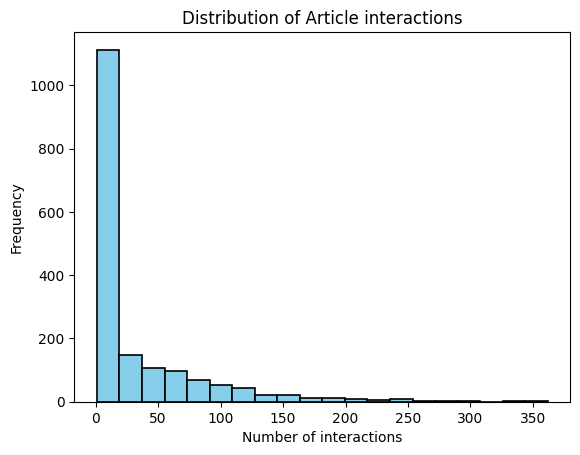

In [11]:
plot_article_clicks(articles_clicks)